Reading CSV...
Amount of data items:48216
Amount of train items:38568
Amount of validation items:9648
Reading output values and images...
Training NN...
Epoch 1/5
18/18 [==============================] - 101s - loss: 0.1151 - val_loss: 0.0378
Epoch 2/5
18/18 [==============================] - 94s - loss: 0.0383 - val_loss: 0.0343
Epoch 3/5
18/18 [==============================] - 102s - loss: 0.0303 - val_loss: 0.0307
Epoch 4/5
18/18 [==============================] - 100s - loss: 0.0274 - val_loss: 0.0245
Epoch 5/5
18/18 [==============================] - 95s - loss: 0.0242 - val_loss: 0.0234


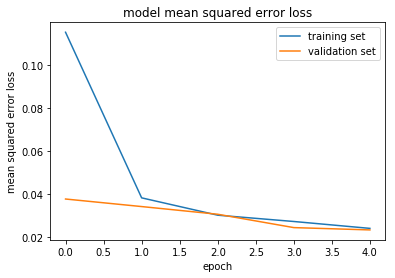

Using the 3 cameras, duplicated with mirroring, gray scale and 66 by 320 size images
Trained model saved...


In [18]:
# modules import section
import csv
import cv2
import sklearn
from random import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

# import data
# data buffers
input_images = []
samples = []
output_values = []
base_path = './data/'
data_file_csv = open(base_path + 'driving_log.csv')
data_reader = csv.reader(data_file_csv)
first_line = True
factor_for_pre_process = 6 #Get 3 images per line and flipped version = 6 images per CSV line
# read csv file
print('Reading CSV...')
for line in data_reader:
    if first_line:
        first_line = False
    else:
        samples.append(line)
                     
print('Amount of data items:' + str(len(samples) * factor_for_pre_process))

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Amount of train items:' + str(len(train_samples) * factor_for_pre_process))
print('Amount of validation items:' + str(len(validation_samples) * factor_for_pre_process))

# read images and output values
print('Reading output values and images...')

# Correction for perspective of different camaras frmo different angles
steering_correction = 0.2
cropped_height = 66
cropped_width = 320
batch_size=2048
# Format image to [66, 320, 1]
def format_image(X):
    X_proc = np.zeros((cropped_height, cropped_width, 1))
    
    for x in range(0, cropped_width-1):
        for y in range(0, cropped_height-1):
            X_proc[y, x, 0] = X[y, x]
    return X_proc

# Generator to process data on demand and be able to process large amount of samples
def generator(samples, batch_size=batch_size):
    num_samples = len(samples)
    counter = 0
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            input_images = []
            output_values = []
            for batch_sample in batch_samples:
                for i in range(3):
                    image_file_name = batch_sample[i]
                    image_full_filename = image_file_name.split('/')[-1]
                    image_path = base_path + 'IMG/' + image_full_filename
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    image = image[70:70 + cropped_height, 0:cropped_width]
                    #plt.imshow(image, cmap = "gray")
                    #plt.show()            
                    input_images.append(image)
                    counter +=1
                    if counter % 1000 == 0:
                        print("Proc images:" + str(len(input_images)))

                output_value_steering = float(batch_sample[3])
                output_value_steering_left = output_value_steering + steering_correction
                output_value_steering_right = output_value_steering - steering_correction
                output_values.append(output_value_steering)
                output_values.append(output_value_steering_left)
                output_values.append(output_value_steering_right)

            aug_input_images = []
            aug_output_values = []
            
            for input_image, output_value in zip(input_images, output_values):
                aug_input_images.append(input_image)
                aug_output_values.append(output_value)
                aug_input_images.append(cv2.flip(input_image, 1))
                aug_output_values.append(-1.0 * output_value)
                
            # Free memory
            input_images = []
            output_values = []
            
            X_train_data = np.zeros((len(aug_input_images), cropped_height, cropped_width, 1))
            counter = 0
            for aug_input_image in aug_input_images:
                X_train_data[counter] =  format_image(aug_input_image)
                counter += 1
                if counter % 1000 == 0:
                    print("Formated images:" + str(counter))

            # convert to np arrays
            y_train_data = np.array(aug_output_values)

            # Free memory
            aug_input_images = []
            aug_output_values = []
            
            yield sklearn.utils.shuffle(X_train_data, y_train_data)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
    
#create a LeNet covnet with keras
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 320, 1)))
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

# Train covnet
print('Training NN...')
model.compile(loss='mse', optimizer='adam')
fit_history = model.fit_generator(train_generator, 
                                  steps_per_epoch=int(len(train_samples) / batch_size * factor_for_pre_process), 
                                  validation_data=validation_generator,
                                  validation_steps=int(len(validation_samples) / batch_size * factor_for_pre_process), epochs=5, verbose=1)

# Plot cost history
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Save model to be used later by drive.py
model.save('model.h5')
print("Using the 3 cameras, duplicated with mirroring, gray scale and 66 by 320 size images")
print('Trained model saved...')